#COLLEGAMENTO A GOOGLE DRIVE, INSTALLAZIONE PACCHETTI, IMPORT LIBERIE NECESSARIE E DEFINIZIONE DELLA CLASSE DISTANZINATOR

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install pyyaml==5.1
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html

     |████████████████████████████████| 276kB 14.1MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44074 sha256=ed09e2345569b007e8328409251187b60640abfd653e2914b96b481961da4c71
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.2MB 3.1MB/s 
     |████████████████████████████████| 51kB 5.0MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-cp37-none-any.whl size=58543 sha256=8878bfa9eb90eda27a5989e6f1495f5f9c699870920bd603b67cab0c09a99dbd
  Stored in directory: /root/.cache/pip/wheels/d2/ee/3a/5c531df777c03d8c67f22c65f97d6f75321087482d05a9b218
Successfully built fvcore


In [5]:
import numpy as np

import tqdm

import os
from os.path import join

import statistics

import json

import cv2

import random

from google.colab.patches import cv2_imshow

import torch
assert torch.__version__.startswith("1.8") 
from torch import nn

from collections import defaultdict

import torch.optim
from torch.optim import SGD
from torch.optim import Adam

from torch.utils.tensorboard import SummaryWriter

import tensorflow as ts

import matplotlib
from matplotlib import pyplot as plt

from sklearn.utils import shuffle

import time

import detectron2
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.data.catalog import Metadata
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

In [6]:
print('Controls')
print('Torch Version: ',torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Using: ',device)

Controls
Torch Version:  1.8.1+cu101
Using:  cpu


In [7]:
class distanzinator(nn.Module):
  def __init__(self,architecture,activation_function=nn.SiLU):
    super(distanzinator,self).__init__()

    self.model_data=[architecture,activation_function.__name__]

    self.activation_function=activation_function

    self.linear_functions=[]    
    for i in range(len(architecture)-1):
      self.linear_functions.append(nn.Linear(architecture[i],architecture[i+1]))
    self.linear_functions=nn.ModuleList(self.linear_functions)

    self.losses_train=[]
    self.losses_test=[]

  def forward(self,x):
    activations=x
    for i in range(len(self.linear_functions)-1):
      output=self.linear_functions[i](activations)
      activations=self.activation_function()(output)
    output=self.linear_functions[-1](activations)
    return output
 
  #FUNZIONE DI TRAINING
  #IN INPUT DI DATASET DI TRAINING E DI TESTING
  #LEARNING RATE, MOMENTUM E NUMERO DI EPOCHE
  #IL TRAINING VIENE FATTO CON SGD
  #LA FUNZIONE DI LOSS USATA È LA L1LOSS
  def allena(self,training_x,training_y,testing_x,testing_y,learning_rate=1e-5,momentum=.9,epochs=100):    
    criterion=nn.L1Loss()
    optimizer=SGD(self.parameters(),learning_rate,momentum=momentum)

    start_time=time.time()
    for e in range(epochs):
      self.train()

      out=self.forward(training_x)
      l=criterion(out.view(-1),training_y)
      l.backward()
      l_train=l.item()
      self.losses_train.append(l.item())

      optimizer.step()
      optimizer.zero_grad()

      self.eval()
      with torch.set_grad_enabled(False):
        y_test = self.forward(testing_x)
        l = criterion(y_test.view(-1),testing_y)
        self.losses_test.append(l.item())

      current_time_elapsed=round((time.time()-start_time)/60,3)
      print('Epoch ',e+1,'/',epochs,'\t   Tempo trascorso: ',current_time_elapsed,'\t Eta: ',round(current_time_elapsed*(epochs-e)/(e+1),3),'\t Training Loss: ',l_train,'\t Testing Loss: ',l.item())

    #PLOT DELLE FUNZIONI DI LOSS DI TRAINING E DI TESTING
    plt.figure()
    plt.plot(range(len(self.losses_train)),self.losses_train,color='red',label='Training Loss')
    plt.title('Loss function (Training)')
    plt.xlabel('Epoca')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()
    plt.savefig('training_loss'+str(self.model_data)+'.pdf')

    plt.figure()
    plt.plot(range(len(self.losses_test)),self.losses_test,color='blue',label='Testing Loss')
    plt.title('Loss function (Testing)')
    plt.xlabel('Epoca')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()
    plt.savefig('testing_loss'+str(self.model_data)+'.pdf')


  def clean_losses(self):
    self.losses_train=[]
    self.losses_test=[]

  #FUNZIONE CHE FA LA VALUTAZIONE DELLE PRESTAZIONI DEL MODELLO
  #DA IN OUTPUT UNA SERIE DI STATISTICHE SUGLI ERRORI E LA REC CURVE
  def valuta(self,training_x,training_y,testing_x,testing_y): 
    #STATISTICHE SUL TRAINING SET 
    error_counter_5=0
    error_counter=0
    rel_error_counter=0
    somma=0
    somma_errore_abs=0
    errori_vs_distanza=defaultdict(lambda:[])
    

    for i in range(len(training_x)):
      out_modello=self.forward(training_x[i])
      out_teorico=training_y[i]
      errore=torch.abs(out_teorico-out_modello).item()
      somma_errore_abs+=errore
      relative_error=errore/out_teorico*100
      somma+=relative_error.item()
      if errore>10 :
        error_counter+=1
      if errore>5 :
        error_counter_5+=1
      if torch.abs(relative_error)>10:
        rel_error_counter+=1
      errori_vs_distanza[int(out_teorico)]+=[errore]
      
    print('\\begin{table}[]\n\\begin{tabular}{ll}')
    print(f'Modello & {self.model_data} \\\\')
    print(f'Errore medio (training set) & {round(somma_errore_abs/len(training_x),2)}cm \\\\')
    print(f'Errori maggiori di 5cm (training set) & {round(100*error_counter_5/len(training_x),2)}\% dei casi\\\\')
    print(f'Errori maggiori di 10cm (training set) & {round(100*error_counter/len(training_x),2)}\% dei casi\\\\')
    print(f'Errore relativo medio (training set) & {round(somma/len(training_x),2)}\% \\\\')
    print(f'Errori relativi maggiori del 10\\% (training set) & {round(rel_error_counter/len(training_x)*100,2)}\% dei casi \\\\')
    for k,v in sorted(errori_vs_distanza.items()):
      print(f'Errore medio a {k}cm (training set): & {round(statistics.mean(v),3)}cm ({round(statistics.mean(v)/k*100,3)}\%)\\\\')


    #STATISTICHE SUL TESTING SET
    error_counter_5=0
    error_counter=0
    rel_error_counter=0
    somma=0
    somma_errore_abs=0
    errori_vs_distanza=defaultdict(lambda:[])
    

    for i in range(len(testing_x)):
      out_modello=self.forward(testing_x[i])
      out_teorico=testing_y[i]
      errore=torch.abs(out_teorico-out_modello).item()
      somma_errore_abs+=errore
      relative_error=errore/out_teorico*100
      somma+=relative_error.item()
      if errore>10 :
        error_counter+=1
      if errore>5 :
        error_counter_5+=1
      if torch.abs(relative_error)>10:
        rel_error_counter+=1
      errori_vs_distanza[int(out_teorico)]+=[errore]
      

    print(f'Errore medio (testing set) & {round(somma_errore_abs/len(testing_x),2)}cm \\\\')
    print(f'Errori maggiori di 5cm (testing set) & {round(100*error_counter_5/len(testing_x),2)}\% dei casi\\\\')
    print(f'Errori maggiori di 10cm (testing set) & {round(100*error_counter/len(testing_x),2)}\% dei casi\\\\')
    print(f'Errore relativo medio (testing set) & {round(somma/len(testing_x),2)}\% \\\\')
    print(f'Errori relativi maggiori del 10\\% (testing set) & {round(rel_error_counter/len(testing_x)*100,2)}\% dei casi \\\\')
    for k,v in sorted(errori_vs_distanza.items()):
      print(f'Errore medio a {k}cm (testing set): & {round(statistics.mean(v),3)}cm ({round(statistics.mean(v)/k*100,3)}\%)\\\\')
    print('\\end{tabular}\n\\end{table}')


    out_modello_testing=self.forward(testing_x)
    out_modello_training=self.forward(training_x)
    errors=torch.linspace(0,100.,100)
    n_errors_test=[]
    n_errors_train=[]
    for error in errors:
      counter=0
      counter_train=0
      for i in range(len(out_modello_testing)):
        if torch.abs(out_modello_testing[i]-testing_y[i])*100./testing_y[i]>error:
          counter+=1
        if torch.abs(out_modello_training[i]-training_y[i])*100./training_y[i]>error:
          counter_train+=1
      n_errors_test.append(1-(counter/len(testing_y)))
      n_errors_train.append(1-(counter_train/len(training_y)))


    plt.figure()
    plt.plot(errors,n_errors_test,label='REC testing')
    plt.plot(errors,n_errors_train,label='REC training',color='red')
    plt.title('REC curve')
    plt.xlabel('Relative error')
    plt.ylabel('Cumulated accuracy')
    plt.legend()
    plt.yticks([.5,.75,.9,.95])
    plt.xticks(np.linspace(0,100,11))
    plt.grid(True)
    plt.savefig('REC_curve'+str(self.model_data)+'.pdf')

  #PRENDE IN INPUT UNA FOTO E DA COME OUTPUT QUELLO CHE DEVO DARE IN INPUT ALLA RETE
  #SE NELLA FOTO RICONOSCE PI\'U CARTELLI ALLORA DAR\'A IN OUTPUT UN ARRAY CON TUTTI GLI INPUT DA PASSARE ALLA RETE
  def image_to_data(self,image_path,predictor_model,print_output='n'):
    #CARICO L'IMMAGINE
    im=cv2.imread(image_path)
    #FACCIO UN RESIZE DELL'IMMAGINE CHE PERMETTE DI AVERE UNA MASCHERA PIÙ REGOLARE
    im=cv2.resize(im,(400,300))
    im_shape=im.shape
    im_height=im_shape[0]
    im_width=im_shape[1]

    #DÒ L'IMMAGINE AL PREDICTOR
    output=predictor_model(im)

    masks_out=output['instances'].pred_masks

    #ESTRAGGO DALL'OUTPUT DEL PREDICTOR LE MASCHERE NON VUOTE
    mask_out=torch.where(masks_out.cpu()!=False)

    #VEDO QUANTE MASCHERE HO TROVATO
    indici_maschere=set(mask_out[0].tolist())

    #SEPARO IN LISTE DIVERSE LE MASCHERE
    maschere=[]
    for indice in indici_maschere:
      temp=torch.where(mask_out[0]==indice)
      start=temp[0][0]
      lenght=temp[0][-1]-start
      maschere+=[[torch.narrow(mask_out[1],0,start,lenght),torch.narrow(mask_out[2],0,start,lenght)]]


    myinputs=[]

    #PER OGNI MASCHERA TROVATA ESTRAGGO LE 17 FEATURES
    for mask_out in maschere:
      #CREO LA MASCHERA RUOTATA DI 45 GRADI (A MENO DI UN FATTORE DI NORMALIZZAZIONE IRRILEVANTE)
      mask_rotated45=[mask_out[0]-mask_out[1],mask_out[0]+mask_out[1]]

      max1=np.argmax(mask_out[0])
      min1=np.argmin(mask_out[0])
      max2=np.argmax(mask_out[1])
      min2=np.argmin(mask_out[1])

      r45max1=np.argmax(mask_rotated45[0])
      r45min1=np.argmin(mask_rotated45[0])
      r45max2=np.argmax(mask_rotated45[1])
      r45min2=np.argmin(mask_rotated45[1])

      #L'AREA COPERTA DALLA MASCHERA LA CALCOLO COME IL NUMERO DI PIXELS RICONOSCIUTI COME APPARTENTENTI
      #ALLA MASCHERA DIVISO IL NUMERO DI PIXELS TOTALI DELLA FOTO
      area=len(mask_out[1])/(im_height*im_width)

      myinput=torch.Tensor([
        mask_out[0][max1]/im_height,mask_out[1][max1]/im_width,
        mask_out[0][min1]/im_height,mask_out[1][min1]/im_width,     
        mask_out[0][max2]/im_height,mask_out[1][max2]/im_width,     
        mask_out[0][min2]/im_height,mask_out[1][min2]/im_width,
        mask_out[0][r45max1]/im_height,mask_out[1][r45max1]/im_width,
        mask_out[0][r45min1]/im_height,mask_out[1][r45min1]/im_width,     
        mask_out[0][r45max2]/im_height,mask_out[1][r45max2]/im_width,     
        mask_out[0][r45min2]/im_height,mask_out[1][r45min2]/im_width,
        area
      ])      


      #A SECONDA DEL TIPO DI INPUT CHE VUOLE IL MODELLO ESTRAGGO LE FEATURES GIUSTE
      if self.model_data[0][0]==8:
        pos=[0,1,2,3,4,5,6,7]
      elif self.model_data[0][0]==9:
        pos=[0,1,2,3,4,5,6,7,16]
      elif self.model_data[0][0]==16:
        pos=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
      elif self.model_data[0][0]==17:
        pos=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
      else:
        print('Not sure on how to handle this...')

      myinputs+=[torch.Tensor([myinput[y] for y in pos])]

    #SE RICHIESTO STAMPO L'OUTPUT DEL PREDICTOR
    if print_output=='y':
      v = Visualizer(im[:, :, ::-1],
                    metadata=metadata_poor, 
                    scale=1
      )
      out = v.draw_instance_predictions(output["instances"].to("cpu"))
      cv2_imshow(out.get_image()[:, :, ::-1])

    return myinputs

  #PRENDE UN IMMAGINE, LA DA A DETECTRON, PREPROCESSA L'OUTPUT DEL PREDICTOR E POI LO PASSA ALLA RETE PER VALUTARE LA DISTANZA
  #SE TROVA PIÙ MASCHERE LE TRATTA COME INPUT DIVERSI, QUINDI SE IN UNA FOTO RICONOSCE N CARTELLI DARÀ IN OUTPUT UN VETTORE CON N DISTANZE
  def image_to_distance(self,image_path,predictor_model,print_output='n'):
    inputs=self.image_to_data(image_path=image_path,predictor_model=predictor_model,print_output=print_output)
    outputs=[]
    for input in inputs:
      outputs+=[self.forward(input).item()]
    return outputs

#CARICAMENTO DEI MODELLI ALLENATI E DEFINIZIONE DEI METADATA PER IL PREDICTOR
LA PRIMA CELLA SERVE A SETTARE LA TRESHOLD DEL PREDICTOR

In [10]:
#QUI CHIEDO LA TRESHOLD DEL PREDICTOR
predictor_treshold=.85

In [11]:
#CARICO I MODELLI DI DETECTRON2 E DEL DISTANZINATOR

#QUI DICO DOVE LI TROVA
distanzinator_model_path='drive/MyDrive/MLProject_final/Modelli_Distanzinator/modello[[16, 16, 1], \'SiLU\'].pt'
#distanzinator_model_path='drive/MyDrive/MLProject_final/Modelli_Distanzinator/modello[[16, 8, 4, 1], \'SiLU\'].pt'
detectron2_model_dir='drive/MyDrive/MLProject_final/detector2_training_output'

#CARICO IL DISTANZINATOR
modello_distanzinator=torch.load(distanzinator_model_path)

#DEFINISCO I METADATA PER DETECTRON2 COSÌ NON HO BISOGNO DI CARICARLI DAL DATASET
metadata_poor = Metadata()
metadata_poor.set(thing_classes = ['HighVoltageSign'])

#CARICO IL PREDICTOR
cfg = get_cfg()
cfg.MODEL.DEVICE=device

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = os.path.join(detectron2_model_dir, "model_final.pth")
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

#QUI SETTO LA TRESHOLD
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = predictor_treshold

predictor = DefaultPredictor(cfg)

#ESEMPIO DI UTILIZZO DEL DISTANZINATOR

In [12]:
#Path dell'immagine da analizzare
image_path='drive/MyDrive/MLProject_final/Demo/fotodemo1_100cm.jpg'

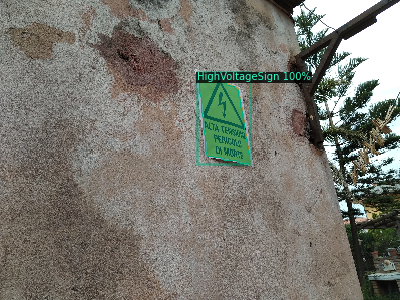

Il cartello dista  [111.55550384521484] cm


In [13]:
distanza=modello_distanzinator.image_to_distance(image_path,predictor_model=predictor,print_output='y')
if distanza==[]:
  print('Non sono stati trovati cartelli in questa foto.')
elif len(distanza)==1:
  print('Il cartello dista ',distanza,'cm')
else:
  print('I cartelli distano ',distanza,'cm')